In [16]:
using Optim, LsqFit
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles
using Statistics
using Turing
using DataFrames

In [17]:
pyplot(grid=:off)

Plots.PyPlotBackend()

In [18]:
ENV["COLUMNS"]=120
figdir = "figures/";

# Viral load data fitting

Data for influenza from


## Data set

10 mice with 13 data points each

In [19]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


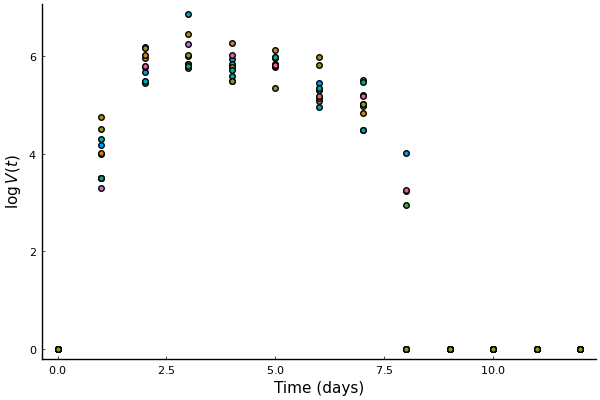

In [20]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

## Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [21]:
H(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -6.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];

cost (generic function with 1 method)

## Data fitting

In [22]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

Get a first estimate using optimization for the prior distributions

In [23]:
par0 = [0.10, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 52351

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37968           0.00000 
         7.72606           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 



 * Status: failure

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    52351
    f(x) calls:    52351
    ∇f(x) calls:   0


## Mixed-effects model

In [50]:
M, n = size(data)

(10, 13)

In [29]:
sampler = PG(10); nsamples = 1000; nchains = 4;

In [71]:
LogVirusLoad(tdata[5], par0...)

4.902010911820291

In [74]:
@model function VLFmixedeffects(t, data, p₀)
    # For each individual i, v[i, j] is the observation at time t[j]
    tmax = maximum(t)
    M, n = size(data)
    # Prior distributions
    s = 0.1 # ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    # Fixed and random effects
    β = [a₁, a₂, b₁, b₂, α, logVmax]
    σ_β = 0.1 # ~ Exponential(0.1)
    b = MvNormal(6, σ_β)
    ϕ = β + b
    print(ϕ)
    σ_ϵ = 1.0 # ~ Exponential(1.0)
    ϵ = Normal(0, σ_ϵ)
    # Model
    threshold = 0
#     for i ∈ eachrow(data)
#         for j ∈ eachcol(data)
#             println(LogVirusLoad(t[j], ϕ...))
#             data[i, j] = LogVirusLoad(t[j], ϕ...) + ϵ
#         end
#     end
    v = data[1, :]
    v = LogVirusLoad.(t, ϕ...) + ϵ
end

VLFmixedeffects (generic function with 1 method)

In [75]:
chains = mapreduce(c -> sample(VLFmixedeffects(tdata, data, fit.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

IsoNormal(
dim: 6
μ: [0.972781793108023, 3.0724582701786383, 6.4181324691783805, 7.674881215680724, 0.4832037396927934, 6.0432838112733425]
Σ: [0.010000000000000002 0.0 0.0 0.0 0.0 0.0; 0.0 0.010000000000000002 0.0 0.0 0.0 0.0; 0.0 0.0 0.010000000000000002 0.0 0.0 0.0; 0.0 0.0 0.0 0.010000000000000002 0.0 0.0; 0.0 0.0 0.0 0.0 0.010000000000000002 0.0; 0.0 0.0 0.0 0.0 0.0 0.010000000000000002]
)


LoadError: MethodError: no method matching iterate(::IsoNormal)
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [46]:
s = 0
for i in 1:10
    s = s + i
end
s

55

Plot error bars using 95% confidence interval

Sample for the posterior and predict, however, this does not include uncertainty from the data.